## **Technical Demo: MCMC-Powered Algorithm Redistricting of Colorado's Congressional Map**

This Jupyter notebook will demonstrate how we can use MCMC methods to redistrict Colorado's congressional delegation.

### **Importing Dependencies**

Prior to running the code, make sure that all the dependencies have been imported. You may need to install some packages if this code chunk sends an error message.

In [30]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
seed_value=46

Make sure that these python files are in the same folder as this Jupyter folder. These helper files have important functions!

In [31]:
from generate_data import *
from mcmc_driver import *

### **Extracting the Graph**

Let's load up a NetworkX graph that represents Colorado's counties. Each node represents a Colorado county, while edges denote contiguity. Every node has an assigned integer ID, and all the nodes have the following attributes:

- name
- population
- PVI
    - the county's partisan lean
    - positive values indicate Democrat bias
    - negative values indicate Republican bias

In [32]:
graph = get_colorado_graph(edge_path = "county.csv", node_path = "data_by_county.csv")
test_index = 10
node = graph.nodes()[test_index]
print(node["population"])

9355


Let's match all the integer IDs with node names.

In [33]:
def get_node_numbers_and_names(graph):
    node_info_list = [(node_number, node_data['name']) for node_number, node_data in graph.nodes(data=True)]
    return node_info_list

# Assuming you have the graph loaded already
colorado_graph = get_colorado_graph(edge_path="county.csv", node_path="data_by_county.csv")

# Call the function to get node numbers and names
node_info_list = get_node_numbers_and_names(colorado_graph)

# Print the list of node numbers and names
for node_info in node_info_list:
    print(node_info)

(0, 'Adams')
(1, 'Alamosa')
(2, 'Arapahoe')
(3, 'Archuleta')
(4, 'Baca')
(5, 'Bent')
(6, 'Boulder')
(7, 'Broomfield')
(8, 'Chaffee')
(9, 'Cheyenne')
(10, 'Clear Creek')
(11, 'Conejos')
(12, 'Costilla')
(13, 'Crowley')
(14, 'Custer')
(15, 'Delta')
(16, 'Denver')
(17, 'Dolores')
(18, 'Douglas')
(19, 'Eagle')
(20, 'El Paso')
(21, 'Elbert')
(22, 'Fremont')
(23, 'Garfield')
(24, 'Gilpin')
(25, 'Grand')
(26, 'Gunnison')
(27, 'Hinsdale')
(28, 'Huerfano')
(29, 'Jackson')
(30, 'Jefferson')
(31, 'Kiowa')
(32, 'Kit Carson')
(33, 'La Plata')
(34, 'Lake')
(35, 'Larimer')
(36, 'Las Animas')
(37, 'Lincoln')
(38, 'Logan')
(39, 'Mesa')
(40, 'Mineral')
(41, 'Moffat')
(42, 'Montezuma')
(43, 'Montrose')
(44, 'Morgan')
(45, 'Otero')
(46, 'Ouray')
(47, 'Park')
(48, 'Phillips')
(49, 'Pitkin')
(50, 'Prowers')
(51, 'Pueblo')
(52, 'Rio Blanco')
(53, 'Rio Grande')
(54, 'Routt')
(55, 'Saguache')
(56, 'San Juan')
(57, 'San Miguel')
(58, 'Sedgwick')
(59, 'Summit')
(60, 'Teller')
(61, 'Washington')
(62, 'Weld')
(63,

The `add_attributes_to_graph` function can be used to modify node attributes for the graph.

In [34]:
def add_attributes_to_graph(graph):
    for node_id, node_data in graph.nodes(data=True):
        attributes = node_data
        graph.nodes[node_id].update(attributes)
# Call the function to add attributes
add_attributes_to_graph(colorado_graph)

# Now you can access the 'population' attribute directly
test_index = 10
population = colorado_graph.nodes[test_index]['PVI']
print(population)

4


### **Defining Subgraphs**

Each subgraph represents a congressional district in Colorado. To initialize our algorithm, we will set 8 subgraphs, with each subgraph representing a current congressional district in-place right now.

In [35]:
colorado_graph=get_colorado_graph(edge_path = "county.csv", node_path = "data_by_county.csv")
# Manually create subgraphs to intialize to current districting
subgraph_nodes_list = [
    [16],
    [29,54,35,25,59,10,24,6,19],
    [41,52,23,39,49,15,26,43,57,46,17,56,55,27,42,33,53,3,33,40,1,11,12,28,51,45,36],
    [9,44,38,58,48,61,63,18,21,37,32,13,31,5,50,4],
    [20],
    [0,2],
    [30,34,47,8,22,14,60],
    [7,62]
    # Add more subgraphs as needed
]

colorado_subgraphs = []

# Create subgraphs and add them to the list
for subgraph_nodes in subgraph_nodes_list:
    subgraph = colorado_graph.subgraph(subgraph_nodes)
    colorado_subgraphs.append(subgraph)

Let's check the graph's correctness by calculating the total population. Colorado has roughly 5.8 million people as of November 2023.

In [36]:
total_population=calculate_total_population(colorado_graph)
print(total_population)

5839926


### **Rating Population**

Congressional redistricting criteria states that each congressional district should have roughly equal population. Thus, each computer-generated map will have a population score to assess how balanced the population spread is for each congressional district (i.e., subgraph).

In [37]:
c_pop=.000000005
def populationscore(graph,subgraphs):
    totalsum=0
    districtaverage=total_population/len(subgraphs)
    for i, subgraph in enumerate(subgraphs, start=1):
        # Calculate the sum of populations for each subgraph
        population_sum = sum(graph.nodes[node]['population'] for node in subgraph.nodes)
        totalsum+=(population_sum-districtaverage)**2
    return(c_pop*totalsum)
populationscore(colorado_graph,colorado_subgraphs)

1779.5140037775

### **Rating PVI**

Congressional redistricting criteria favors competitive congressional districts. Consequently, each computer-generated map will assess the competitiveness of a state's congressional districts by assessing each district's PVI. A PVI of 0 suggests that no political party has a partisan advantage over it.

In [38]:
c_pvi=0.00003
def PVIscore(graph, subgraphs):
    total_score = 0

    for subgraph in subgraphs:
        # Calculate the sum of PVI scores for each subgraph
        pvi_sum = sum(graph.nodes[node]['PVI']*graph.nodes[node]['population'] for node in subgraph.nodes)
        total_score += abs(pvi_sum)

    return c_pvi * total_score
PVIscore(colorado_graph,colorado_subgraphs)

1804.51926

Now that we can calculate scores for the population and PVI, we can return a total score to represent the graph's validity.

In [39]:
lambda_J=1
def totalscorefunction(graph,subgraph):
    return lambda_J*populationscore(graph,subgraph)+(1-lambda_J)*PVIscore(graph,subgraph)

### **Graphing the Result**

Now that we've implemented ways to score congressional districts, we can visualize the result by plotting graphs in real-time.

### **Setting a Layout**

The layout for the NetworkX will be an 8x8 square of nodes to roughly match Colorado's shape.

In [40]:
layout = {41: (0, 7), 54: (1, 7), 29: (2, 7), 35: (3, 7), 62: (4, 7), 38: (5, 7), 48: (6, 7), 58: (7, 7),
          52: (0, 6), 59: (1, 6), 19: (2, 6), 25: (3, 6), 6:  (4, 6), 7:  (5, 6), 0:  (6, 6), 44: (7, 6),
          23: (0, 5), 10: (1, 5), 24: (2, 5), 30: (3, 5), 16: (4, 5), 2:  (5, 5), 61: (6, 5), 63: (7, 5),
          39: (0, 4), 8:  (1, 4), 34: (2, 4), 47: (3, 4), 60: (4, 4), 18: (5, 4), 21: (6, 4), 37: (7, 4),
          49: (0, 3), 22: (1, 3), 20: (2, 3), 14: (3, 3), 13: (4, 3), 31: (5, 3), 9:  (6, 3), 32: (7, 3),
          43: (0, 2), 15: (1, 2), 26: (2, 2), 55: (3, 2), 51: (4, 2), 5:  (5, 2), 50: (6, 2), 4:  (7, 2),
          57: (0, 1), 46: (1, 1), 27: (2, 1), 40: (3, 1), 17: (4, 1), 28: (5, 1), 53: (6, 1), 1:  (7, 1),
          3:  (0, 0), 11: (1, 0), 12: (2, 0), 36: (3, 0), 45: (4, 0), 56: (5, 0), 42: (6, 0), 33: (7, 0)}

### **Visualizing Subgraphs**

Draw the subgraphs along with the population and PVI scores.

In [41]:
def visualize_subgraphs3(graph, subgraphs, highlighted_edge="none"):

    # Draw the original graph
    nx.draw(graph, pos=layout, with_labels=True, font_weight='bold', node_color='lightgray', edge_color='gray', node_size=700)

    # Draw each subgraph with a different color
    for i, subgraph in enumerate(subgraphs, start=1):
        nx.draw(subgraph, pos=layout, with_labels=True, font_weight='bold', node_color=f'C{i}', edge_color=f'C{i}', node_size=700)

    # Highlight the specified edge if it's not "none"
    if highlighted_edge != "none":
        nx.draw_networkx_edges(graph, pos=layout, edgelist=[highlighted_edge], edge_color='purple', width=5)

    # Add text annotations in the bottom right corner
    pop_score_text = f'Pop Score: {populationscore(graph, subgraphs)}'
    pvi_score_text = f'PVI Score: {PVIscore(graph, subgraphs)}'
    plt.text(0.8, -0.1, pop_score_text, transform=plt.gca().transAxes, fontsize=10, color='black')
    plt.text(0.8, -0.05, pvi_score_text, transform=plt.gca().transAxes, fontsize=10, color='black')

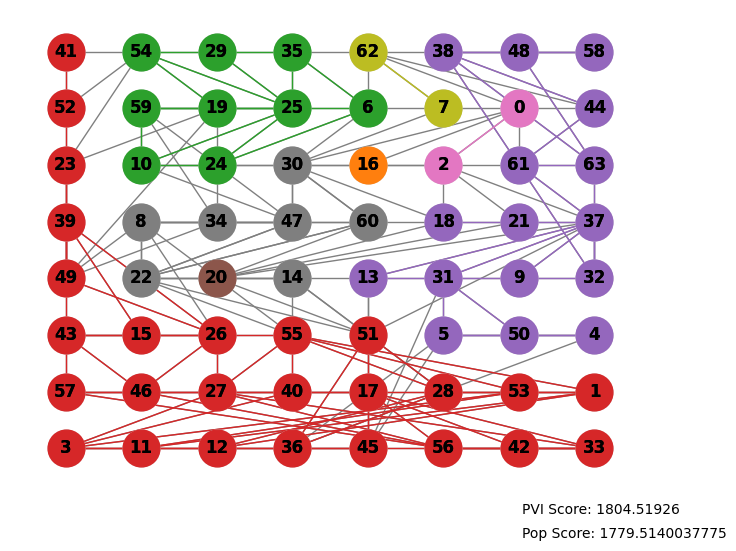

In [42]:
visualize_subgraphs3(colorado_graph,colorado_subgraphs)

Let's check if all the subgraphs are connected to one another. This should return `True` as we've only graphed the current congressional representation. In other words, no MCMC iterations have run yet.

In [43]:
def are_subgraphs_connected(graph, subgraphs):
    for subgraph in subgraphs:
        if not nx.is_connected(graph.subgraph(subgraph.nodes())):
            return False
    return True
print(are_subgraphs_connected(colorado_graph,colorado_subgraphs))

True


In [44]:
def are_subgraphs_nonempty(subgraphs):
    return all(len(subgraph) > 0 for subgraph in subgraphs)

In [45]:
populationscore(colorado_graph,colorado_subgraphs)

1779.5140037775

### **Running the MCMC Algorithm**

Now that we've imported the graph and defined the subgraphs, we can run the MCMC algorithm and start redistricting.

In [46]:
beta=0.05
import numpy as np

def get_a_valid_conflicted_edge_colorado(graph, subgraphs):
    conflicted_edge = get_random_edge_between_subgraphs(graph, subgraphs)
    
    while True:
        proposed_graph, proposed_subgraphs = create_proposed_state(graph, subgraphs, conflicted_edge)

        # Check if all proposed subgraphs are non-empty
        if are_subgraphs_nonempty(proposed_subgraphs):
            # Check if the proposed subgraph is connected
            if are_subgraphs_connected(proposed_graph, proposed_subgraphs):
                return  proposed_graph, proposed_subgraphs, conflicted_edge # Exit the loop if connected

        # If not connected, generate a different conflicted edge and try again
        conflicted_edge = get_random_edge_between_subgraphs(graph, subgraphs)

def Modified_one_iteration_of_MCMC_colorado(graph,subgraphs,proposed_graph, proposed_subgraphs):
    con1 = len(get_edges_between_subgraphs(graph, subgraphs))
    con2 = len(get_edges_between_subgraphs(proposed_graph, proposed_subgraphs))
    probfromscorefunctions = np.exp(-1 * beta * (totalscorefunction(proposed_graph, proposed_subgraphs) - totalscorefunction(graph, subgraphs))) 
    transitionprobability = min(1, con1 / con2, probfromscorefunctions)

    # Generate a random number between 0 and 1
    random_number = np.random.rand()

    # Check if the random number is less than the transition probability
    if random_number < transitionprobability:
        return proposed_graph, proposed_subgraphs
    else:
        return graph, subgraphs

### **Recording Results**

We'll store the frames for the MCMC algorithm in a folder and connect them using an animation. For this demonstration, we'll run 100 iterations of the MCMC algorithm.

In [61]:
import os

In [62]:
# Set the frames directory
frames_directory = r"C:\Users\nharr\OneDrive\Documents\ColoradoLambda1MCMC"
# frames_directory = r"C:\Users\lukel\OneDrive\Desktop\Fall 2023\CS333\markov-redistricting\frames"
os.makedirs(frames_directory, exist_ok=True)

# Rest of your code remains unchanged
num_iterations = 100
graph1 = colorado_graph
subgraphs1 = colorado_subgraphs

for iteration in range(num_iterations):
    proposed_graph, proposed_subgraphs, conflicted_edge = get_a_valid_conflicted_edge_colorado(graph1, subgraphs1)
    if not are_subgraphs_connected(proposed_graph, proposed_subgraphs):
        print("PROBLEM")
        break
    visualize_subgraphs3(graph1, subgraphs1, conflicted_edge)

    # Save the first frame
    frame_filename = f"frame_{iteration * 2}.png"
    frame_path = os.path.join(frames_directory, frame_filename)
    plt.savefig(frame_path, format='png')
    plt.clf()

    graph1, subgraphs1 = Modified_one_iteration_of_MCMC_colorado(graph1, subgraphs1, proposed_graph, proposed_subgraphs)
    visualize_subgraphs3(graph1, subgraphs1)

    # Save the second frame
    frame_filename = f"frame_{iteration * 2 + 1}.png"
    frame_path = os.path.join(frames_directory, frame_filename)
    plt.savefig(frame_path, format='png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

503.9280249675
503.9280249675
1569.15726
1804.51926


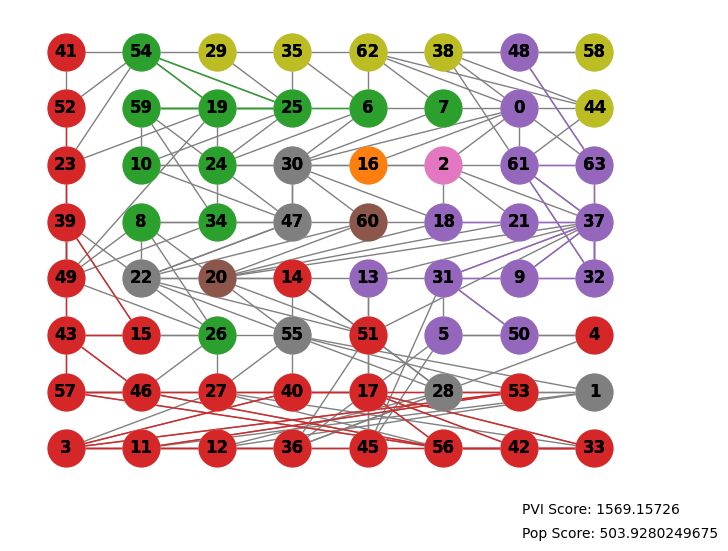

In [21]:
visualize_subgraphs3(graph1,subgraphs1)
print(populationscore(graph1,subgraphs1))
print(populationscore(graph1,subgraphs1))
print(PVIscore(graph1,subgraphs1))
print(PVIscore(colorado_graph,colorado_subgraphs))

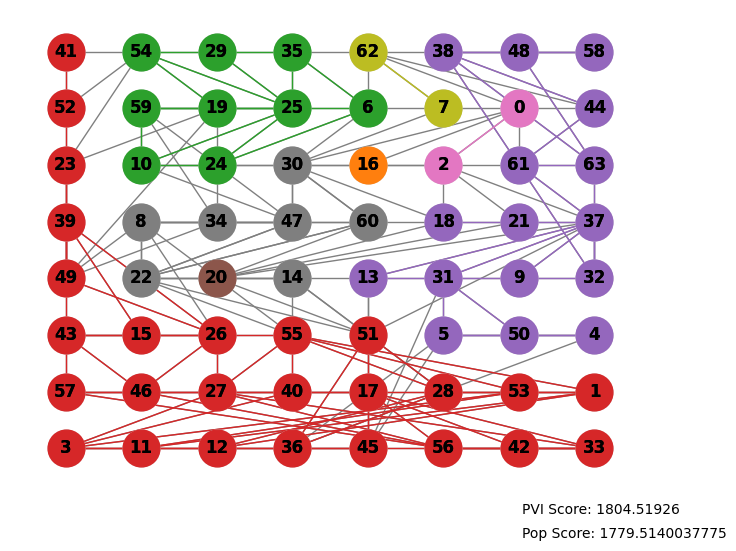

In [22]:
visualize_subgraphs3(colorado_graph,colorado_subgraphs)

### **Exporting Results**

Now that we've collected all the animation frames for the video, we can connect them to output an mp4 file.

In [63]:
import cv2

# Path to the directory containing PNG frames
frames_directory = "frames/"
# frames_directory = r"C:\Users\nharr\OneDrive\Documents\ColoradoLambda1MCMC"

# Output video file name
output_video_filename = "colorado_lambda1_video.mp4"
# output_video_filename = r"C:\Users\nharr\OneDrive\Documents\colorado_lambda1_video.mp4"

# List all frame files in the directory and sort them based on the numeric part of the file name
frame_files = sorted([f for f in os.listdir(frames_directory) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))

# Read the first frame to get dimensions
first_frame = cv2.imread(os.path.join(frames_directory, frame_files[0]))
height, width, _ = first_frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use an appropriate codec (e.g., mp4v)
video_writer = cv2.VideoWriter(output_video_filename, fourcc, 4, (width, height))

# Write each frame to the video
for frame_file in frame_files:
    frame_path = os.path.join(frames_directory, frame_file)
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

# Release the VideoWriter
video_writer.release()

### **Comparing Results**

Let's represent the final set of congressional districts drawn by our algorithm as subgraphs and compare the results with Colorado's congressional districts in real life. This step is done to evaluate algorithmic accuracy.

In [47]:
# final subgraphs are based on node groupings from frame 199
final_subgraphs = [
    [16],
    [49,54,59,10,22,19,24,26,25,47,6,60,7],
    [41,52,23,39,43,57,3,8,15,46,11,34,27,12,14,55,40,36,51,17,45,5,28,56,53,42,4,1,33],
    [2,31,48,61,9,50,58,63,32],
    [20,13,21,37],
    [38,0,44],
    [30,18],
    [29,35,62]
]

Let's calculate the population of each district.

In [48]:
def find_district_pop(graph, subgraphs):
    
    # store the populatoin of each district
    subgraph_pop = []
    graph_nodes = graph.nodes
    
    for subgraph in subgraphs:
        
        # calculate the pvi score for each congressional district
        pop_sum = sum(graph_nodes[node]['population'] for node in subgraph.nodes)
        subgraph_pop.append(pop_sum)

    return subgraph_pop

We can now calculate the population of each congressional district.

In [49]:
# find the district PVIs
subgraph_pop = find_district_pop(colorado_graph,colorado_subgraphs)

for i in range(1, 9):
    print(f"Population of CO-0{i}: {subgraph_pop[i-1]}")
print(f"Expected Average Population: {sum(subgraph_pop)//8}")

Population of CO-01: 713252
Population of CO-02: 837420
Population of CO-03: 720332
Population of CO-04: 517230
Population of CO-05: 740567
Population of CO-06: 1183383
Population of CO-07: 701445
Population of CO-08: 426297
Expected Average Population: 729990


Let's find a way to calculate the PVI of each district.

In [50]:
def find_district_PVI(graph, subgraphs):
    
    # store the pvi of each district
    subgraph_pvi = []
    graph_nodes = graph.nodes
    
    for subgraph in subgraphs:
        
        # calculate the pvi score for each congressional district
        pvi_sum = sum(graph_nodes[node]['PVI']*graph_nodes[node]['population'] for node in subgraph.nodes)
        pop_sum = sum(graph_nodes[node]['population'] for node in subgraph.nodes)
        subgraph_pvi.append(round(pvi_sum / pop_sum))

    return subgraph_pvi

We are now able to find the PVI of each district.

In [51]:
# find the district PVIs
subgraph_pvi = find_district_PVI(colorado_graph,colorado_subgraphs)

for i in range(1, 9):
    print(f"PVI of CO-0{i}: {subgraph_pvi[i-1]}")

PVI of CO-01: 30
PVI of CO-02: 15
PVI of CO-03: -5
PVI of CO-04: -10
PVI of CO-05: -5
PVI of CO-06: 9
PVI of CO-07: 4
PVI of CO-08: -4


### **Archived Code**

These code chunks are from previous drafts prior to the finalized algorithm.

In [52]:
def visualize_subgraphs2(graph, subgraphs, highlighted_edge="none"):
    pos = nx.spring_layout(graph, seed=seed_value)  # You can use a different layout if you prefer

    # Draw the original graph
    nx.draw(graph, pos=layout, with_labels=True, font_weight='bold', node_color='lightgray', edge_color='gray', node_size=700)

    # Draw each subgraph with a different color
    for i, subgraph in enumerate(subgraphs, start=1):
        nx.draw(subgraph, pos=layout, with_labels=True, font_weight='bold', node_color=f'C{i}', edge_color=f'C{i}', node_size=700)

    # Highlight the specified edge if it's not "none"
    if highlighted_edge != "none":
        nx.draw_networkx_edges(graph, pos, edgelist=[highlighted_edge], edge_color='purple', width=2)

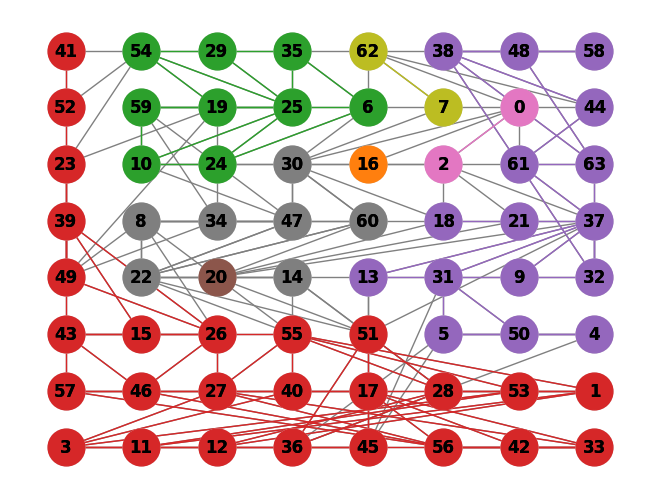

In [53]:
colorado_graph=get_colorado_graph(edge_path = "county.csv", node_path = "data_by_county.csv")
# Manually create subgraphs to intialize to current districting
subgraph_nodes_list = [
    [16],
    [29,54,35,25,59,10,24,6,19],[41,52,23,39,49,15,26,43,57,46,17,56,55,27,42,33,53,3,33,40,1,11,12,28,51,45,36],[9,44,38,58,48,61,63,18,21,37,32,13,31,5,50,4],[20],[0,2],[30,34,47,8,22,14,60],[7,62]
    # Add more subgraphs as needed
]

colorado_subgraphs = []

# Create subgraphs and add them to the list
for subgraph_nodes in subgraph_nodes_list:
    subgraph = colorado_graph.subgraph(subgraph_nodes)
    colorado_subgraphs.append(subgraph)
visualize_subgraphs2(colorado_graph,colorado_subgraphs)